In [5]:
pip install scikit-learn==1.2.2

In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA

Preprocessing

In [35]:

data = pd.read_csv('orig_all_1s_numeric_final_merged_synthetic_respondents.csv', encoding='latin1')

multi_select_cols = [
    'q5_1', 'q5_2', 'q5_3', 'q5_4', 'q5_5',
    'q8_1', 'q8_2', 'q8_3', 'q8_4', 'q8_5', 'q8_6',
    'q9_1', 'q9_2', 'q9_3', 'q9_4', 'q9_5', 'q9_6'
]
data[multi_select_cols] = data[multi_select_cols].fillna(0)

q6_cols = ['q6_1', 'q6_2', 'q6_3', 'q6_4']
all_values = {1, 2, 3, 4, 5}

def fill_q6_5(row):
    existing_values = {row[q] for q in q6_cols if not pd.isna(row[q])}
    missing_values = all_values - existing_values
    return missing_values.pop() if len(missing_values) == 1 else np.nan

data['q6_5'] = data.apply(lambda row: fill_q6_5(row) if pd.isna(row['q6_5']) else row['q6_5'], axis=1)

response_cols = ['q12', 'q13', 'q17', 'q19', 'q24', 'q27', 'q31', 'q35']
data[response_cols] = data[response_cols].fillna('No Response')

for col in response_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert non-numeric to NaN

#Handle pairwise deletion and other preprocessing
target_column = 'q21'
if target_column in data.columns:
    y = data[target_column]
    X = data.drop(columns=[target_column])
else:
    y = None
    X = data

if 'respondent_id' in X.columns:
    X = X.drop(columns=['respondent_id'])

if y is not None:
    valid_idx = y.notna()
    X = X[valid_idx]
    y = y[valid_idx]

missing_threshold = 0.90
cols_to_drop = X.columns[X.isnull().mean() > missing_threshold]
X = X.drop(columns=cols_to_drop)

X = X.fillna(-1)

print(f"Shape after missing value handling: Features = {X.shape}, Target = {y.shape if y is not None else 'N/A'}")

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

pca = PCA(n_components=0.95)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled), columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print(f"PCA reduced dataset shape: {X_pca.shape}")

#Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


Shape after missing value handling: Features = (1000, 72), Target = (1000,)
PCA reduced dataset shape: (1000, 64)


Anomaly Detection

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


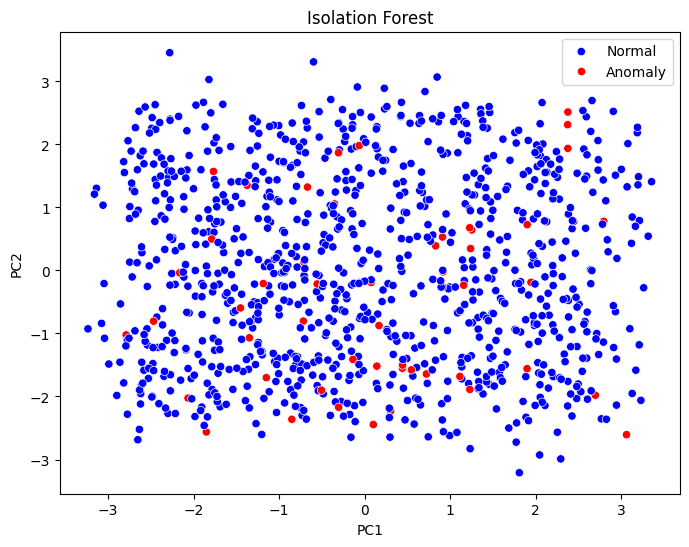

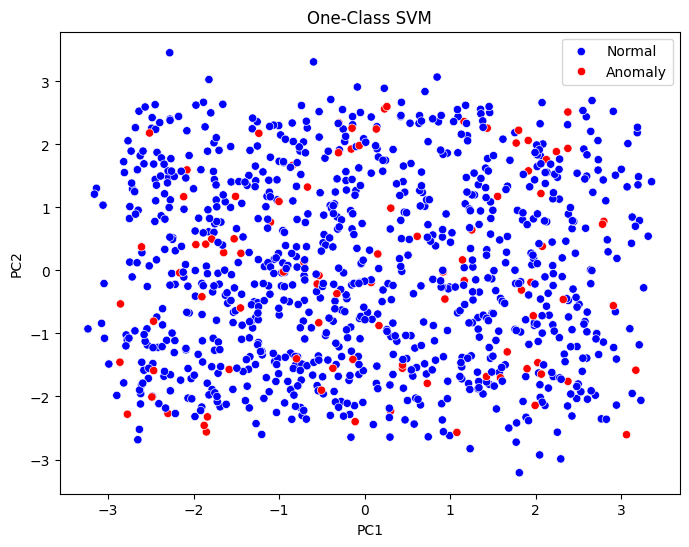

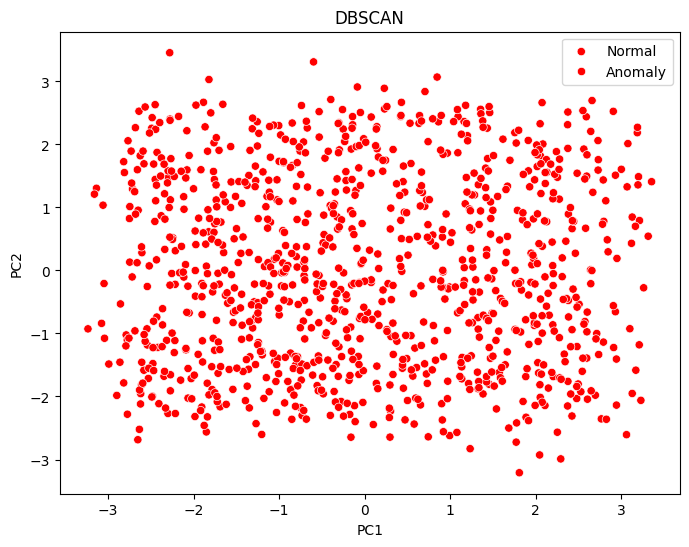

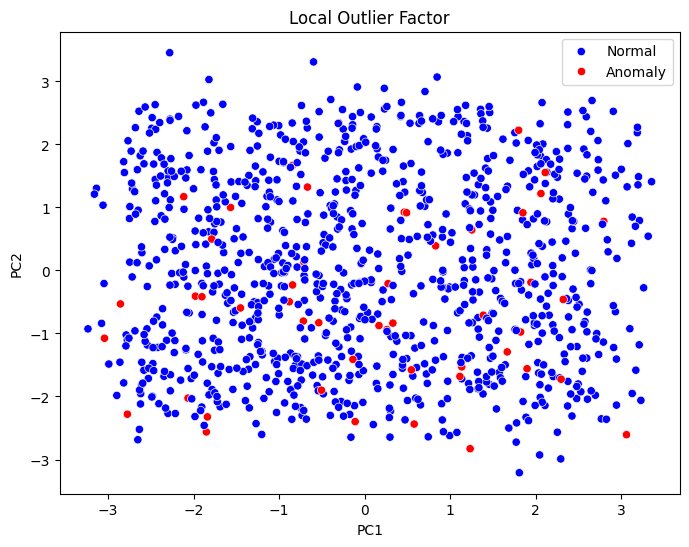

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


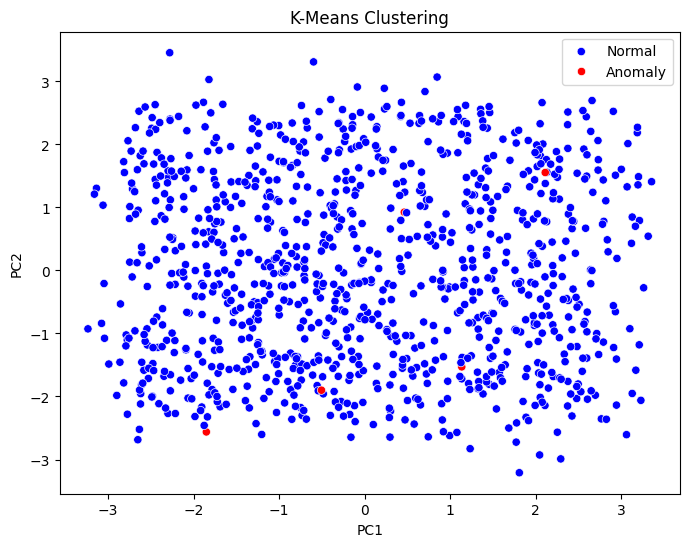

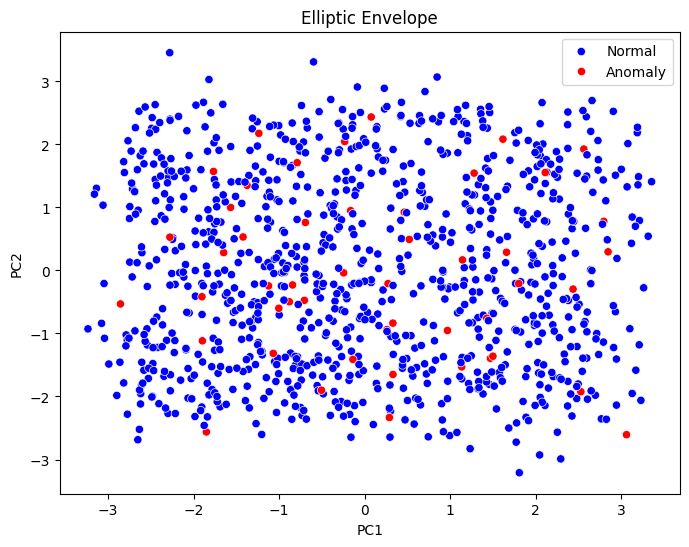


Summary of Anomalies and Normal Points Detected:
Isolation Forest: Anomalies = 50, Normal = 950
One-Class SVM: Anomalies = 94, Normal = 906
DBSCAN: Anomalies = 1000, Normal = 0
Local Outlier Factor: Anomalies = 50, Normal = 950
K-Means Clustering: Anomalies = 5, Normal = 995
Elliptic Envelope: Anomalies = 50, Normal = 950


In [36]:
def plot_anomalies(X, anomalies, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X['PC1'], y=X['PC2'], hue=anomalies, palette={1: 'blue', -1: 'red'})
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(labels=['Normal', 'Anomaly'])
    plt.show()

# 1. Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(X_pca)
plot_anomalies(X_pca, iso_labels, title="Isolation Forest")

# 2. One-Class SVM
svm = OneClassSVM(nu=0.05, gamma='scale')
svm_labels = svm.fit_predict(X_pca)
plot_anomalies(X_pca, svm_labels, title="One-Class SVM")

# 3. DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)
dbscan_labels = [1 if lbl != -1 else -1 for lbl in dbscan_labels]
plot_anomalies(X_pca, dbscan_labels, title="DBSCAN")

# 4. Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_labels = lof.fit_predict(X_pca)
plot_anomalies(X_pca, lof_labels, title="Local Outlier Factor")

# 5. K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_pca)
distances = kmeans.transform(X_pca).min(axis=1)
threshold = distances.mean() + 3 * distances.std()
kmeans_labels = [-1 if dist > threshold else 1 for dist in distances]
plot_anomalies(X_pca, kmeans_labels, title="K-Means Clustering")

# 6. Elliptic Envelope
elliptic = EllipticEnvelope(contamination=0.05, random_state=42)
elliptic.fit(X_pca)
elliptic_labels = elliptic.predict(X_pca)
elliptic_labels = [-1 if lbl == -1 else 1 for lbl in elliptic_labels]
plot_anomalies(X_pca, elliptic_labels, title="Elliptic Envelope")

iso_labels = np.array(iso_labels)
svm_labels = np.array(svm_labels)
dbscan_labels = np.array(dbscan_labels)
lof_labels = np.array(lof_labels)
kmeans_labels = np.array(kmeans_labels)
elliptic_labels = np.array(elliptic_labels)

# Summary of anomaly counts for each technique
techniques = [
    'Isolation Forest',
    'One-Class SVM',
    'DBSCAN',
    'Local Outlier Factor',
    'K-Means Clustering',
    'Elliptic Envelope',
]
labels = [iso_labels, svm_labels, dbscan_labels, lof_labels, kmeans_labels, elliptic_labels]
summary = {
    tech: (np.sum(l == -1), np.sum(l == 1)) for tech, l in zip(techniques, labels)
}

print("\nSummary of Anomalies and Normal Points Detected:")
for tech, (anomalies, normal) in summary.items():
    print(f"{tech}: Anomalies = {anomalies}, Normal = {normal}")

Identifing technique with the most balanced anomaly ratio

In [37]:
# Techniques and their corresponding predictions (excluding DBSCAN)
techniques = [
    'Isolation Forest',
    'One-Class SVM',
    'Local Outlier Factor',
    'K-Means Clustering',
    'Elliptic Envelope',
]
labels = [iso_labels, svm_labels, lof_labels, kmeans_labels, elliptic_labels]

evaluation_results = {}

for tech, preds in zip(techniques, labels):
    preds = np.array(preds)
    try:
        # Calculate proportion of anomalies
        num_anomalies = sum(preds == -1)
        total_points = len(preds)
        anomaly_ratio = num_anomalies / total_points

        evaluation_results[tech] = {
            "Total Points": total_points,
            "Anomalies Detected": num_anomalies,
            "Anomaly Ratio": anomaly_ratio,
        }
    except Exception as e:
        print(f"Error evaluating {tech}: {e}")

print("\nSummary of Evaluation Results:")
for tech, metrics in evaluation_results.items():
    print(f"\n{tech}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")

# Identify technique with the most balanced anomaly ratio (e.g., 0.05–0.2)
best_technique = max(
    evaluation_results,
    key=lambda x: abs(0.1 - evaluation_results[x]["Anomaly Ratio"])
)
print(f"\nBest Technique Based on Balanced Anomaly Ratio: {best_technique}")



Summary of Evaluation Results:

Isolation Forest:
  Total Points: 1000
  Anomalies Detected: 50
  Anomaly Ratio: 0.05

One-Class SVM:
  Total Points: 1000
  Anomalies Detected: 94
  Anomaly Ratio: 0.094

Local Outlier Factor:
  Total Points: 1000
  Anomalies Detected: 50
  Anomaly Ratio: 0.05

K-Means Clustering:
  Total Points: 1000
  Anomalies Detected: 5
  Anomaly Ratio: 0.005

Elliptic Envelope:
  Total Points: 1000
  Anomalies Detected: 50
  Anomaly Ratio: 0.05

Best Technique Based on Balanced Anomaly Ratio: K-Means Clustering


Visualization of Anomaly Score

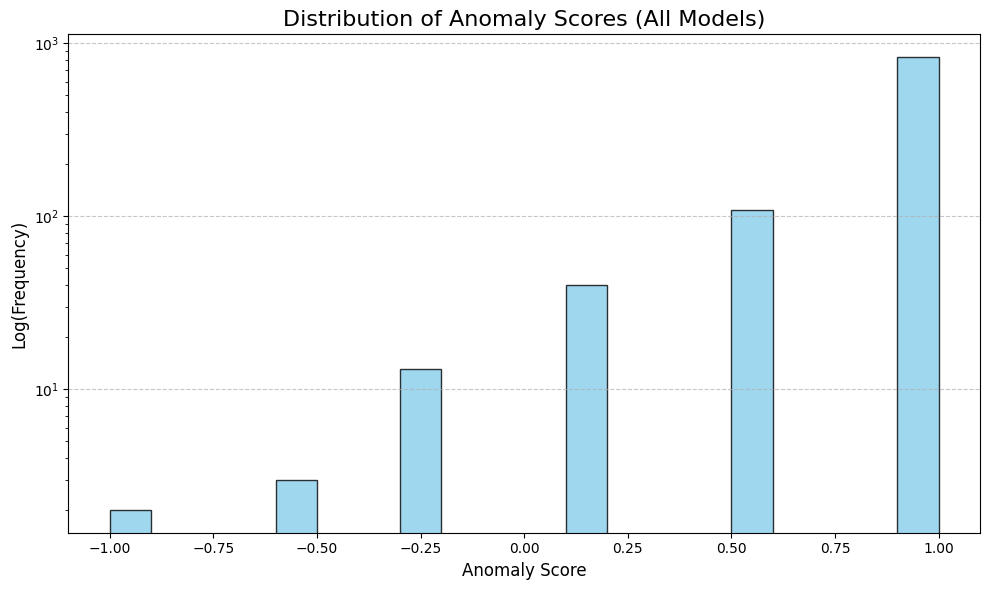

In [38]:
iso_scores = np.array(iso_labels)
lof_scores = np.array(lof_labels)
svm_scores = np.array(svm_labels)
kmeans_scores = np.array(kmeans_labels)
elliptic_scores = np.array(elliptic_labels)

anomaly_scores = (iso_scores + lof_scores + svm_scores + kmeans_scores + elliptic_scores) / 5

plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=20, color='skyblue', edgecolor='black', alpha=0.8)
plt.yscale('log')
plt.title('Distribution of Anomaly Scores (All Models)', fontsize=16)
plt.xlabel('Anomaly Score', fontsize=12)
plt.ylabel('Log(Frequency)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Chioce-Based Conjoint

In [39]:
logit_model = LogisticRegression(max_iter=1000, random_state=42)
logit_model.fit(X_train, y_train)

logit_preds = logit_model.predict(X_test)
logit_accuracy = logit_model.score(X_test, y_test)
print(f"Logistic Regression Accuracy (CBC): {logit_accuracy:.4f}")

# Random Forest for Choice-Based Conjoint
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest R2 Score (CBC): {rf_r2:.4f}")

#Latent Class Analysis
from sklearn.mixture import GaussianMixture

n_classes = 3
gmm = GaussianMixture(n_components=n_classes, random_state=42)
gmm.fit(X_scaled)
latent_classes = gmm.predict(X_scaled)

print("Latent Class Analysis completed. Assigned latent classes to data.")

# Gradient Boosting Machines (GBM)
# XGBoost
gbm_xgb = xgb.XGBRegressor(n_estimators=50, learning_rate=0.01, max_depth=3, random_state=42)
gbm_xgb.fit(X_train, y_train)

xgb_preds = gbm_xgb.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_preds)
print(f"XGBoost R2 Score (GBM): {xgb_r2:.4f}")

# LightGBM
gbm_lgb = lgb.LGBMRegressor(n_estimators=50, learning_rate=0.01, num_leaves=20, random_state=42,verbose=-1)
gbm_lgb.fit(X_train, y_train)

lgb_preds = gbm_lgb.predict(X_test)
lgb_r2 = r2_score(y_test, lgb_preds)
print(f"LightGBM R2 Score (GBM): {lgb_r2:.4f}")

# Multinomial Logit (MNL) Models with Regularization
from sklearn.linear_model import LogisticRegressionCV

mnl_model = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter=1000, random_state=42)
mnl_model.fit(X_train, y_train)

mnl_preds = mnl_model.predict(X_test)
mnl_accuracy = mnl_model.score(X_test, y_test)
print(f"Multinomial Logit Accuracy: {mnl_accuracy:.4f}")

#Model Blending
blended_preds = (
    0.2 * logit_model.predict_proba(X_test)[:, 1] +
    0.3 * rf.predict(X_test) +
    0.3 * gbm_xgb.predict(X_test) +
    0.2 * gbm_lgb.predict(X_test)
)

blended_r2 = r2_score(y_test, blended_preds)
print(f"Blended Model R2 Score: {blended_r2:.4f}")



Logistic Regression Accuracy (CBC): 0.2250
Random Forest R2 Score (CBC): 0.0058
Latent Class Analysis completed. Assigned latent classes to data.
XGBoost R2 Score (GBM): 0.0149
LightGBM R2 Score (GBM): -0.0057
Multinomial Logit Accuracy: 0.2300
Blended Model R2 Score: -0.1429


Visualization of all chioce-based conjoint models

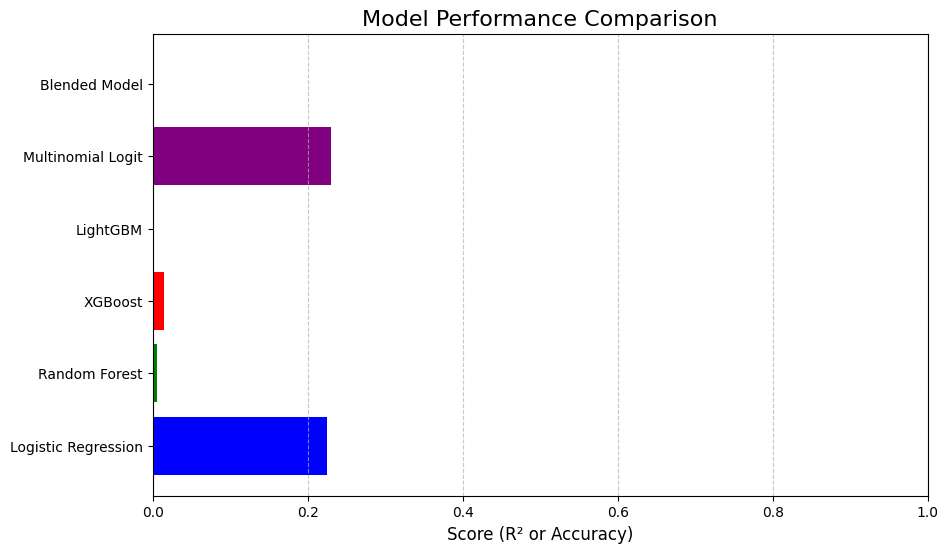

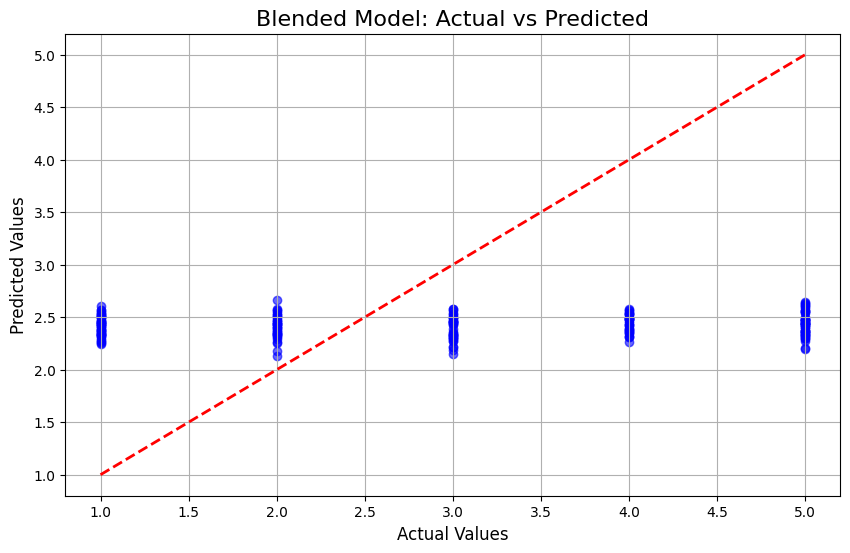

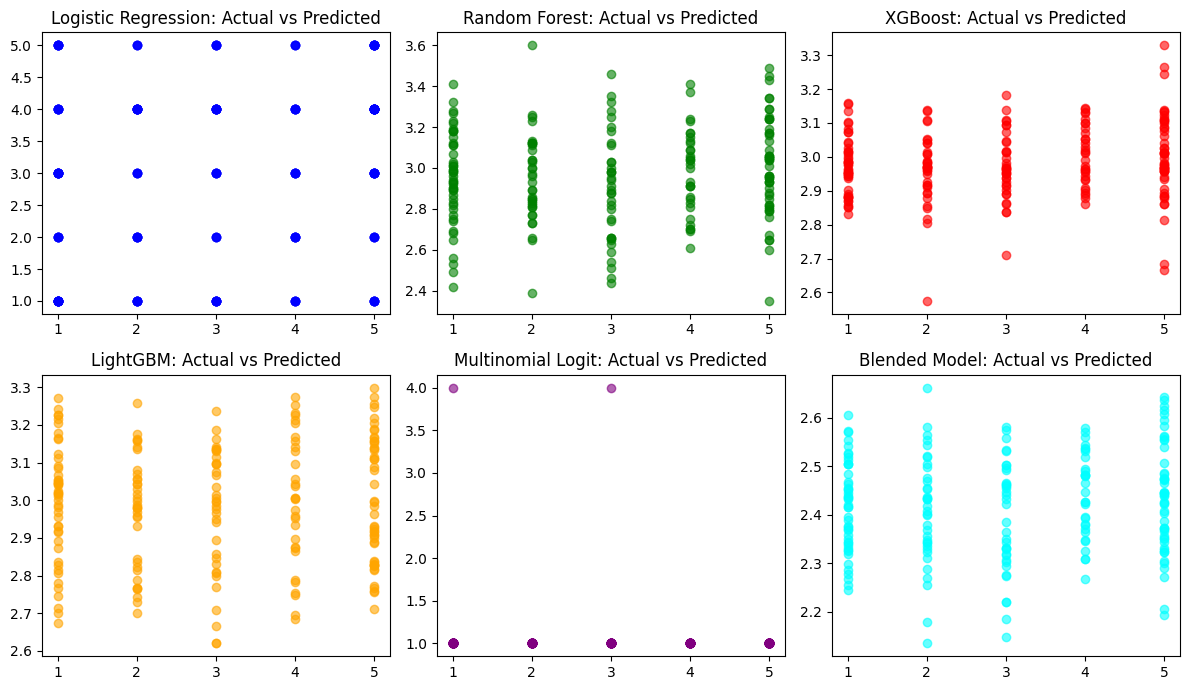

In [40]:
model_names = [
    "Logistic Regression", "Random Forest", "XGBoost", "LightGBM",
    "Multinomial Logit", "Blended Model"
]
model_scores = [
    logit_accuracy, rf_r2, xgb_r2, lgb_r2, mnl_accuracy, blended_r2
]

plt.figure(figsize=(10, 6))
plt.barh(model_names, model_scores, color=['blue', 'green', 'red', 'orange', 'purple', 'cyan'])
plt.xlabel('Score (R² or Accuracy)', fontsize=12)
plt.title('Model Performance Comparison', fontsize=16)
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Visualize Actual vs Predicted for the Blended Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, blended_preds, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)  # Diagonal line
plt.title('Blended Model: Actual vs Predicted', fontsize=16)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid(True)
plt.show()

# Visualize Predicted vs Actual for All Models
plt.figure(figsize=(12, 7))
plt.subplot(2, 3, 1)
plt.scatter(y_test, logit_model.predict(X_test), color='blue', alpha=0.6)
plt.title('Logistic Regression: Actual vs Predicted')

plt.subplot(2, 3, 2)
plt.scatter(y_test, rf_preds, color='green', alpha=0.6)
plt.title('Random Forest: Actual vs Predicted')

plt.subplot(2, 3, 3)
plt.scatter(y_test, xgb_preds, color='red', alpha=0.6)
plt.title('XGBoost: Actual vs Predicted')

plt.subplot(2, 3, 4)
plt.scatter(y_test, lgb_preds, color='orange', alpha=0.6)
plt.title('LightGBM: Actual vs Predicted')

plt.subplot(2, 3, 5)
plt.scatter(y_test, mnl_preds, color='purple', alpha=0.6)
plt.title('Multinomial Logit: Actual vs Predicted')

plt.subplot(2, 3, 6)
plt.scatter(y_test, blended_preds, color='cyan', alpha=0.6)
plt.title('Blended Model: Actual vs Predicted')

plt.tight_layout()
plt.show()
